## Crop Buildings (Preprocessing)

In this colab file, we included some preprocessing code used across different models in our project. This code captured the buildings from each satellite image and then cropped them with padding techniques to make them the same dimensions.

In [ ]:
# libraries
import cv2
from google.colab.patches import cv2_imshow as show
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import math

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Whos Currently Running?
NAME = "ALAN"

In [ ]:
# Identify user and pull image path
if NAME == "PAT":
  img_path_pre = '/content/drive/MyDrive/Capstone Project/Dataset1/train/images/guatemala-volcano_00000000_pre_disaster.png'
elif NAME == "ALAN":
  img_path_pre = "/content/drive/MyDrive/SeniorSpring/ENEE439D/Capstone Project/Dataset1/train/images/socal-fire_00001088_post_disaster.png"
elif NAME == "ANDY":
  img_path_pre = '/content/drive/MyDrive/Spring 2024/ENEE 439D/Capstone Project/Dataset1/train/images/socal-fire_00001088_post_disaster.png'
else:
  print("invalid Name")

# Image cropping
def show_with_size(image, width, height):
    plt.figure(figsize=(width, height))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Show pre-disaster image
img_pre = cv2.imread(img_path_pre)
print("Pre disaster Building Damage Assessment Image: ")
# show_with_size(img_pre, width=8, height=6)  # Adjust width and height as needed

# Show post-disaster image
img_path_post = img_path_pre.replace('pre', 'post')
img_post = cv2.imread(img_path_post)
print("Post disaster Building Damage Assessment Image: ")
# show_with_size(img_post, width=8, height=6)  # Adjust width and height as needed

# get the json data
label_path = img_path_post.replace('png', 'json').replace('images', 'labels')
# takes a while for below code to run so once it runs, work with data variable in new cell
with open(label_path, "rb") as file:
    data = json.load(file)

Pre disaster Building Damage Assessment Image: 
Post disaster Building Damage Assessment Image: 


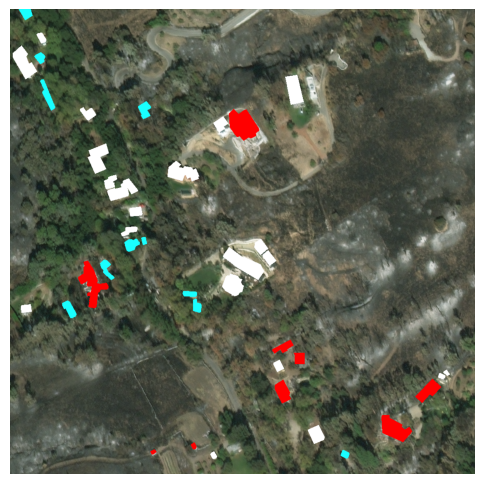

In [ ]:
#Used as a reference for function idea: https://www.kaggle.com/code/lezwon/xview2-challenge#kln-47, but chose a different but similar method
#referene for cv2.fillpoly: https://www.geeksforgeeks.org/draw-a-filled-polygon-using-the-opencv-function-fillpoly/

#Params:
# img -> The target image to draw over: must be from cv2.imread
# data -> The json file for the labels: must be from json.load(file) from "with open(label_path, "rb") as file:"
def draw_lables(img, data):
  for building in data['features']['xy']:

    #split the string
    spaces = building['wkt'].split(' ')

    #remove the first element 'POLYGON'
    spaces.pop(0)
    #remove the parenthesis from the first element
    spaces[0] = spaces[0][2::]
    #remove the parethesis of the last element
    spaces[len(spaces)-1] = spaces[len(spaces)-1][:-2]

    #get rid of the commas in the second point
    for i in range(len(spaces)):
      spaces[i] = spaces[i].replace(",","")

    #make them integers and tuples for points
    points = []
    for i in range(0,len(spaces),2):
      points.append((int(float(spaces[i])), int(float(spaces[i+1]))))

    points = np.array(points)

    #grab the damage label
    damage_label = building["properties"]["subtype"]

    #CV2 uses BGR not RGB
    #default to cyan
    COLOR = (255,255,25)
    if damage_label == "no-damage":
      #no-damage is white
      COLOR = (255,255,255)
    if damage_label == "minor-damage":
      #minor damage is green
      COLOR = (128,255,102)
    if damage_label == "major-damage":
      #major is orange
      COLOR = (0,153,250)
    if damage_label == "destroyed":
      #red for destoyed
      COLOR = (0,0,255)

    #draw the proper polygon
    cv2.fillPoly(img, [points],COLOR)

  show_with_size(img,6,8)

#testing the function

draw_lables(img_pre,data)


In [ ]:
# get the points of each polygon that represents a building
def get_points(json_building):
  #split the string
  spaces = building['wkt'].split(' ')

  # print(spaces)


  #remove the first element 'POLYGON'
  spaces.pop(0)

  #remove the parenthesis from the first element
  spaces[0] = spaces[0][2::]

  #remove the parethesis of the last element
  spaces[len(spaces)-1] = spaces[len(spaces)-1][:-2]

  #get rid of the commas in the second point
  for i in range(len(spaces)):
    spaces[i] = spaces[i].replace(",","")

  # print(spaces)

  #make them integers and tuples for points
  points = []
  for i in range(0,len(spaces),2):
    points.append((int(float(spaces[i])), int(float(spaces[i+1]))))

  points = np.array(points)

  return points

In [ ]:
# make all images the same dimensions
def make_same_dimensions(images):

  # find max row,cols of all images
  max_rows = 0
  max_cols = 0
  for img in images:
    curr_rows, curr_cols, _ = img.shape
    if curr_rows > max_rows:
      max_rows = curr_rows
    if curr_cols > max_cols:
      max_cols = curr_cols

  # print("Max rows : " + str(max_rows))
  # print("Max cols: " + str(max_cols))

  square_dim = max(max_rows , max_cols)

  # print("square_dim: " + str(square_dim))

  new_images = []
  img_count = 1
  # make all images have same dimensions
  for img in images:

    # print("\nimage " + str(img_count))
    img_count+=1

    curr_rows , curr_cols, _ = img.shape

    # print("curr_rows : " + str(curr_rows))
    # print("curr_cols: " + str(curr_cols))

    # add to cols of image if needed
    if square_dim > curr_cols:
      difference = square_dim - curr_cols

      # print("difference in cols: " + str(difference))

      # creates column array with $rows number of rows
      d = np.array([[[0, 0, 0]] for x in range(curr_rows)])
      # print(d.shape)

      # case where you just add one col to the img
      if difference == 1:
          new_img = np.hstack((img, d))
      # case where you add equal amount to left and right of image
      else:
        # add one col to left and right of img
        new_img = np.hstack((img, d))
        new_img = np.hstack((d, new_img))

        # add rest of cols to left/right of img
        for i in range(math.floor(difference/2)-1):
          new_img = np.hstack((new_img, d))
          new_img = np.hstack((d, new_img))

        # if difference is odd, have an extra column to add
        if difference%2 == 1:
          new_img = np.hstack((new_img, d))

    # update variables to match updated image
    curr_rows , curr_cols, _ = new_img.shape

    # add to rows of image if needed
    if square_dim > curr_rows:
      difference = square_dim - curr_rows

      # print("difference in rows: " + str(difference))

      # creates row array with $height number of cols
      d = np.array([[[0, 0, 0] for x in range(curr_cols)]])
      # print(d.shape)

      # case where you just add one row to the img
      if difference == 1:
          new_img = np.vstack((new_img, d))
      # case where you add equal amount to top and bottom of image
      else:
        # add one col to left and right of img
        new_img = np.vstack((new_img, d))
        new_img = np.vstack((d, new_img))

        # add rest of cols to left/right of img
        for i in range(math.floor(difference/2)-1):
          new_img = np.vstack((new_img, d))
          new_img = np.vstack((d, new_img))

        # if difference is odd, have an extra column to add
        if difference%2 == 1:
          new_img = np.vstack((new_img, d))

    new_rows, new_cols, _ = new_img.shape

    # print("\nnew_rows: " + str(new_rows))
    # print("new_cols: " + str(new_cols))

    new_images.append(new_img)

  return new_images

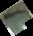

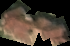

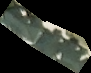

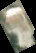

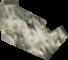

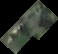

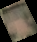

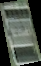

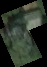

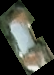

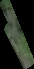

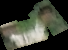

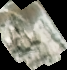

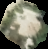

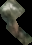

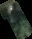

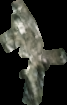

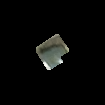

(105, 105, 3)


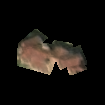

(105, 105, 3)


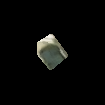

(105, 105, 3)


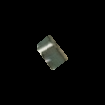

(105, 105, 3)


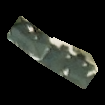

(105, 105, 3)


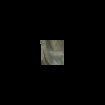

(105, 105, 3)


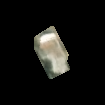

(105, 105, 3)


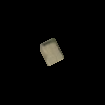

(105, 105, 3)


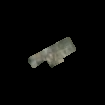

(105, 105, 3)


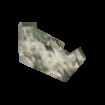

(105, 105, 3)


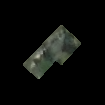

(105, 105, 3)


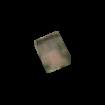

(105, 105, 3)


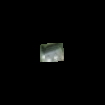

(105, 105, 3)


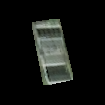

(105, 105, 3)


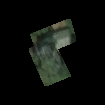

(105, 105, 3)


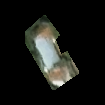

(105, 105, 3)


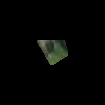

(105, 105, 3)


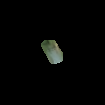

(105, 105, 3)


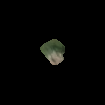

(105, 105, 3)


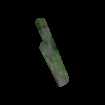

(105, 105, 3)


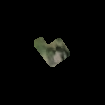

(105, 105, 3)


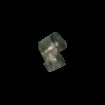

(105, 105, 3)


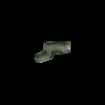

(105, 105, 3)


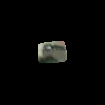

(105, 105, 3)


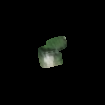

(105, 105, 3)


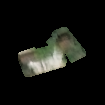

(105, 105, 3)


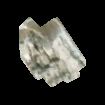

(105, 105, 3)


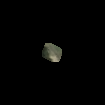

(105, 105, 3)


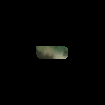

(105, 105, 3)


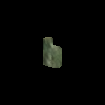

(105, 105, 3)


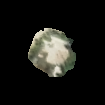

(105, 105, 3)


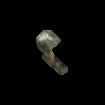

(105, 105, 3)


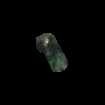

(105, 105, 3)


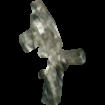

(105, 105, 3)


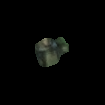

(105, 105, 3)


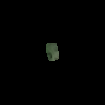

(105, 105, 3)


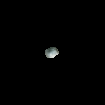

(105, 105, 3)


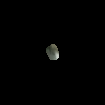

(105, 105, 3)


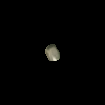

(105, 105, 3)


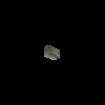

(105, 105, 3)


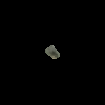

(105, 105, 3)


In [ ]:
# go through all buildings in an image and display image of just the building

images = []

# find the center of each building
for building in data['features']['xy']:
  # print(building)
  points = get_points(building)
  # print(points)
  sum_x = 0
  sum_y = 0
  for x,y in points:
    sum_x += x
    sum_y += y

  center_x = round(sum_x/len(points))
  center_y = round(sum_y/len(points))
  # print(center_x)
  # print(center_y)
  # image[ miny:maxy, minx:maxx]
  # show(img_post[center_y-50:center_y+50, center_x-50:center_x+50])

  # source for below code: https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python

  rect = cv2.boundingRect(points)
  x,y,w,h = rect
  croped = img_post[y:y+h, x:x+w].copy()

  ## (2) make mask
  pts = points - points.min(axis=0)

  mask = np.zeros(croped.shape[:2], np.uint8)
  cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

  ## (3) do bit-op
  dst = cv2.bitwise_and(croped, croped, mask=mask)

  show(dst)
  images.append(dst)

new_images = make_same_dimensions(images)

for img in new_images:
  show(img)
  print(img.shape)

Original: 


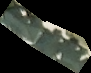


New: 


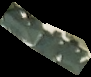

In [ ]:
# Add black border to top/bottom of image

width, height, _ = dst.shape
# creates row array with $height number of cols
d = np.array([[[0, 0, 0] for x in range(height)]])

new = np.vstack((dst, d))
new = np.vstack((new, d))
new = np.vstack((d, new))
new = np.vstack((d, new))

print("Original: ")
show(dst)
print("\nNew: ")
show(new)

# d = [[(0, 0, 0) for x in range(width)] for y in range(2)]


Original: 


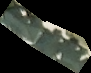


New: 


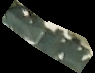

In [ ]:
# Add black border to side edges of image

# creates column array with $width number of rows
d = np.array([[[0, 0, 0]] for x in range(width)])

new = np.hstack((dst, d))
new = np.hstack((new, d))
new = np.hstack((d, new))
new = np.hstack((d, new))

print("Original: ")
show(dst)
print("\nNew: ")
show(new)

In [ ]:
math.floor(3/2)

1